<a href="https://colab.research.google.com/github/HikariJadeEmpire/THNumber_img_classification/blob/main/numberclassifier.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [53]:
#pip install opencv-python
#pip install tensorflow      # keras is run on tensorflow so install tensorflow first
# vv 
#pip install keras

# Choose one (for Cross Validation)
#pip install pycaret
#pip install tune-sklearn ray[tune]

# STEP 1 : Importing

In [54]:

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
#Importing OpenCV - the computer vision library
import cv2

# import the modules - Directory management
import glob
import os
from os import listdir

In [56]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Neural Network
from tensorflow import keras
from tensorflow.keras import layers

from keras.wrappers.scikit_learn import KerasClassifier
from tune_sklearn import TuneGridSearchCV

# STEP 1.1 : SET an important Variables

In [57]:
main_dir = "./Thainumber"

# <h2>STEP 1.2 : Note ( It's not necessary to use. )</h2>

In [58]:
# get the path/directory

Zero_dir = main_dir + "/0"

#for images in os.listdir(One_dir):
 
    # check if the image ends with png
#    if (images.endswith(".png")):
#        print(images)

Original Image Shape (28, 28, 3)


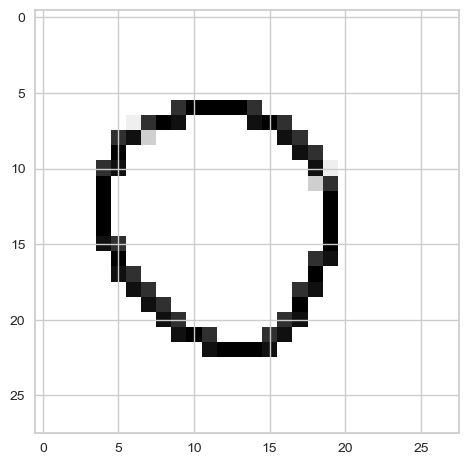

In [59]:
#To read the image 
bgrimg = cv2.imread(str(Zero_dir+'/0-2.png'))

plt.imshow(bgrimg)

#To get rid of the x-ticks and y-ticks on the image axis
#plt.xticks([])
#plt.yticks([])

print('Original Image Shape',bgrimg.shape)

In [60]:
#cv2.imread(str(Zero_dir+'/IMG_0953.png'))

# STEP 2 : Preparing & inspection

Prepare for inspections

In [61]:
file_path_all = list( glob.glob( main_dir + '/**/*.png' ) )

In [62]:
labels = list( map(lambda x: os.path.split( os.path.split(x)[0] )[1] , file_path_all) )

filepath = pd.Series(file_path_all, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

data = pd.concat([filepath, labels], axis=1)

data = data.sample(frac=1).reset_index(drop=True)   # Return a random sample of items from an axis of object.
data

,Filepath,Label
0,./Thainumber\6\IMG_0918.png,6
1,./Thainumber\9\IMG_0942.png,9
2,./Thainumber\3\three.png,3
3,./Thainumber\8\8-02.png,8
4,./Thainumber\3\3-5.png,3
...,...,...
295,./Thainumber\2\IMG_0872.png,2
296,./Thainumber\5\IMG_0909.png,5
297,./Thainumber\5\5-2.png,5
298,./Thainumber\5\5-23.png,5


In [63]:
data.shape

(300, 2)

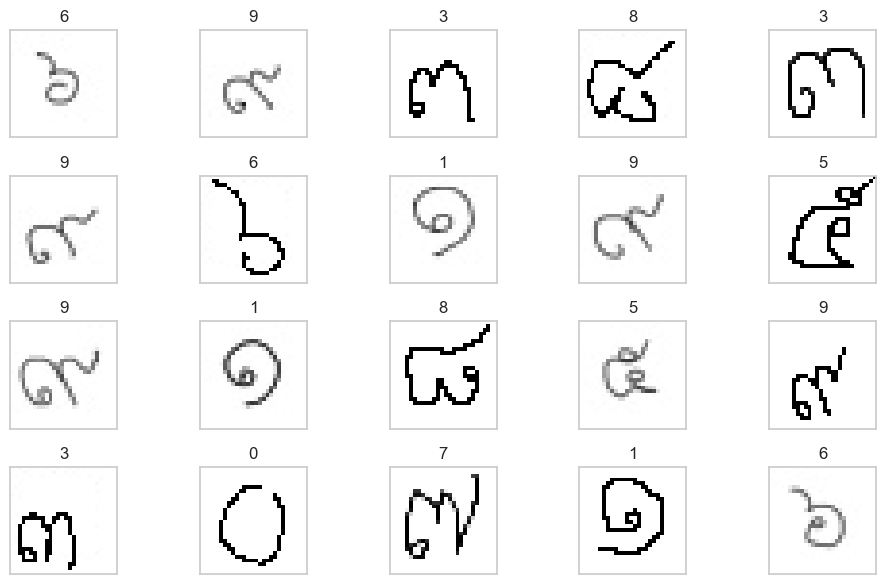

In [64]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10,6), subplot_kw = {'xticks':[],'yticks':[]} )

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Counts')

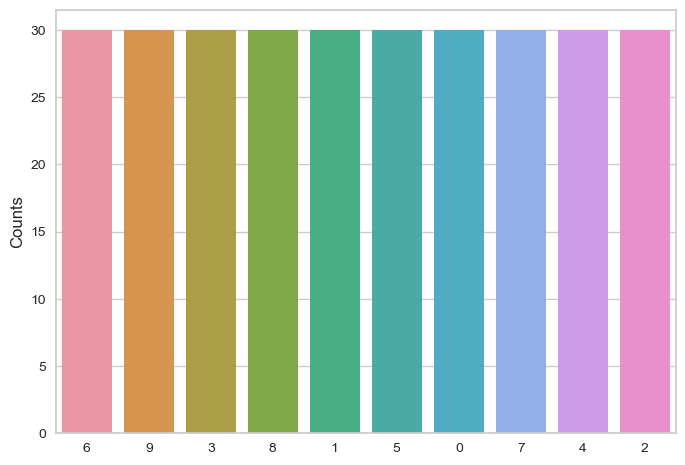

In [65]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.ylabel('Counts')

Prepare for Training

In [66]:
# Prepare X and Y

Before_x = data['Filepath']
y = data['Label']

# To work with X, we need to flatten the images first.
read_x = []

for i in Before_x :
    img_arr = cv2.imread(i)
    img_arr = cv2. cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    img_arr = np.expand_dims(img_arr, 2)
    read_x.append(img_arr)

Almost_x = np.array(read_x)
x = Almost_x/255       # Devide by 255 is to Normalization

In [67]:
print( y.unique(), '\n' )

# Binarize the output

y = preprocessing.label_binarize( y , classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] )
print(y)

['6' '9' '3' '8' '1' '5' '0' '7' '4' '2'] 

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]


In [68]:
X_train, X_test , y_train, y_test = train_test_split( x, y , test_size=0.3, random_state=42 )

print('Train shape =>',X_train.shape , X_test.shape)
print('Test shape =>',y_train.shape , y_test.shape )

Train shape => (210, 28, 28, 1) (90, 28, 28, 1)
Test shape => (210, 10) (90, 10)


# STEP 3 : Train 

Build a Neural Network model for cross validation <br>
E.g set hidden layers , etc.

In [69]:
# Set up model

def create_model(optimizer="rmsprop", kernel_initializer="glorot_uniform"):
    model = keras.Sequential()
    model.add(layers.Dense(100, input_shape=(28,28,1 )))
    model.add(layers.Activation("relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(100, kernel_initializer=kernel_initializer))
    model.add(layers.Activation("relu"))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(10, kernel_initializer=kernel_initializer))
    model.add(layers.Activation("softmax"))  # This special "softmax" a
    model.compile(
        loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model


<h4>Cross Validation : keras</h4>
By : TuneGridSearchCV

In [70]:
model = KerasClassifier(build_fn=create_model)
optimizers = ["rmsprop", "adam"]
kernel_initializer = ["glorot_uniform", "normal"]
epochs = [10, 20]
param_grid = dict(
    optimizer=optimizers,
    nb_epoch=epochs,
    kernel_initializer=kernel_initializer)

grid = TuneGridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)
print(grid_result.best_params_)
print(grid_result.cv_results_)

(_Trainable pid=21880)  [repeated 48x across cluster]
(_Trainable pid=21880) 1/6 [====>.........................] - ETA: 7s - loss: 0.6851 - accuracy: 0.0625 [repeated 7x across cluster]
(_Trainable pid=13780) 2/6 [=========>....................] - ETA: 0s - loss: 0.5006 - accuracy: 0.0469 [repeated 6x across cluster]
(_Trainable pid=13780) 1/2 [==============>...............] - ETA: 0s - loss: 0.3682 - accuracy: 0.0938 [repeated 17x across cluster]
(_Trainable pid=17340) 4/6 [===================>..........] - ETA: 0s - loss: 0.5475 - accuracy: 0.0938 [repeated 7x across cluster]
(_Trainable pid=17340) 5/6 [========================>.....] - ETA: 0s - loss: 0.5514 - accuracy: 0.0875 [repeated 7x across cluster]
(_Trainable pid=13780) 2/2 [==============================] - 0s 10ms/step - loss: 0.3674 - accuracy: 0.1190 [repeated 19x across cluster]
(_Trainable pid=13780) 6/6 [==============================] - ETA: 0s - loss: 0.4262 - accuracy: 0.0952 [repeated 2x across cluster]
(_Traina

(_Trainable pid=21880) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x000001D4ED98C0D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details. [repeated 8x across cluster]


7/7 [==============================] - 1s 56ms/step - loss: 0.3920 - accuracy: 0.0905
{'optimizer': 'rmsprop', 'nb_epoch': 10, 'kernel_initializer': 'normal'}
{'params': [{'optimizer': 'rmsprop', 'nb_epoch': 10, 'kernel_initializer': 'glorot_uniform'}, {'optimizer': 'rmsprop', 'nb_epoch': 10, 'kernel_initializer': 'normal'}, {'optimizer': 'rmsprop', 'nb_epoch': 20, 'kernel_initializer': 'glorot_uniform'}, {'optimizer': 'rmsprop', 'nb_epoch': 20, 'kernel_initializer': 'normal'}, {'optimizer': 'adam', 'nb_epoch': 10, 'kernel_initializer': 'glorot_uniform'}, {'optimizer': 'adam', 'nb_epoch': 10, 'kernel_initializer': 'normal'}, {'optimizer': 'adam', 'nb_epoch': 20, 'kernel_initializer': 'glorot_uniform'}, {'optimizer': 'adam', 'nb_epoch': 20, 'kernel_initializer': 'normal'}], 'split0_test_score': array([0.11904762, 0.0952381 , 0.0952381 , 0.04761905, 0.04761905,
       0.07142857, 0.07142857, 0.04761905]), 'split1_test_score': array([0.0952381 , 0.11904762, 0.04761905, 0.07142857, 0.07142

<h4>Cross Validation : AutoML </h4>
By : Pycaret

In [71]:
from pycaret.classification import *


In [72]:
clf = setup(data, target = 'Label',train_size = 0.7)
top5_model = compare_models(sort = 'Accuracy', fold = 5, n_select = 5)

,Description,Value
0,Session id,8601
1,Target,Label
2,Target type,Multiclass
3,Target mapping,"0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9"
4,Original data shape,"(300, 2)"
5,Transformed data shape,"(300, 2)"
6,Transformed train set shape,"(210, 2)"
7,Transformed test set shape,"(90, 2)"
8,Categorical features,1
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:03:01
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)


In [73]:
display(top5_model)

[SGDClassifier(alpha=0.0001, average=False, class_weight=None,
               early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
               l1_ratio=0.15, learning_rate='optimal', loss='hinge',
               max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
               power_t=0.5, random_state=8601, shuffle=True, tol=0.001,
               validation_fraction=0.1, verbose=0, warm_start=False),
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                      weights='uniform'),
 GaussianNB(priors=None, var_smoothing=1e-09),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        random_

# STEP 4 : Test